# Feature Engineering
Based on our exploratory analysis, we can create new features to better capture patterns that distinguish fraudulent from legitimate transactions.
<br>We will take these insights into consideration for feature engineering:
- Fraud is only committed between customer accounts (C -> C). With this said, no fraudulent transactions involve Merchant (M) or other account types.
- Many fraudulent transactions completely empty the origin account balance.

In [21]:
import numpy as np
import pandas as pd
path = '../data/paysim_synthetic.csv'
data = pd.read_csv(path)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [22]:
# Define feature engineering function
def engineer_features(data):
    df = data.copy()

    # Extract account types
    df['origAccountType'] = data['nameOrig'].str[0]
    df['destAccountType'] = data['nameDest'].str[0]

    # Flag for Customer-to-Customer transactions
    df['C_to_C'] = ((df['origAccountType'] == 'C') & (df['destAccountType'] == 'C')).astype(int)

    # Log-transform amount to reduce skewness
    df['logAmount'] = np.log1p(data['amount'])

    # Balance features
    df['oldbalanceDiff'] = data['oldbalanceOrg'] - data['oldbalanceDest']
    df['newbalanceDiff'] = data['newbalanceOrig'] - data['newbalanceDest']
    df['balanceChangeOrig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
    df['balanceChangeDest'] = data['newbalanceDest'] - data['oldbalanceDest']

    # Check if transaction zeroes out the origin account
    df['isOriginZeroed'] = (data['oldbalanceOrg'] > 0) & (data['newbalanceOrig'] == 0)

    # Ratio of transaction amount to old balance
    # To avoid division by zero, we'll add a small epsilon
    epsilon = 1e-10
    df['amountToOldBalanceRatio'] = data['amount'] / (data['oldbalanceOrg'] + epsilon)

    # Is the transaction amount suspiciously close to the total balance?
    df['isAmountCloseToBalance'] = (
        abs(data['amount'] - data['oldbalanceOrg']) / (data['oldbalanceOrg'] + epsilon) < 0.05
    ) & (data['oldbalanceOrg'] > 0)

    # Error/oddity detection using np.isclose for balance check
    df['errorBalanceOrig'] = ~np.isclose(data['newbalanceOrig'] + data['amount'], data['oldbalanceOrg'])
    df['errorBalanceDest'] = ~np.isclose(data['oldbalanceDest'] + data['amount'], data['newbalanceDest'])

    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=['type', 'origAccountType', 'destAccountType'], drop_first=True)

    return df

In [23]:
# Apply feature engineering
engineered_df = engineer_features(data)

# Check newly created features
original_columns = data.columns.tolist()
new_features = [col for col in engineered_df.columns if col not in original_columns]

In [24]:
# Print summary
print("Newly created features:")
print(new_features)

Newly created features:
['C_to_C', 'logAmount', 'oldbalanceDiff', 'newbalanceDiff', 'balanceChangeOrig', 'balanceChangeDest', 'isOriginZeroed', 'amountToOldBalanceRatio', 'isAmountCloseToBalance', 'errorBalanceOrig', 'errorBalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'destAccountType_M']


In [25]:
print("\nEngineered data shape:", engineered_df.shape)


Engineered data shape: (6362620, 26)


In [26]:
# View newly created dataframe
engineered_df[new_features].head()

,C_to_C,logAmount,oldbalanceDiff,newbalanceDiff,balanceChangeOrig,balanceChangeDest,isOriginZeroed,amountToOldBalanceRatio,isAmountCloseToBalance,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destAccountType_M
0,0,9.194276,170136.0,160296.36,-9839.64,0.0,False,0.057834,False,False,True,0,0,1,0,1
1,0,7.531166,21249.0,19384.72,-1864.28,0.0,False,0.087735,False,False,True,0,0,1,0,1
2,1,5.204007,181.0,0.00,-181.00,0.0,True,1.000000,True,False,True,0,0,0,1,0
3,1,5.204007,-21001.0,0.00,-181.00,-21182.0,True,1.000000,True,False,True,1,0,0,0,0
4,0,9.364703,41554.0,29885.86,-11668.14,0.0,False,0.280795,False,False,True,0,0,1,0,1


In [28]:
# Convert boolean columns into int
bool_columns = engineered_df.select_dtypes(include='bool').columns
engineered_df[bool_columns] = engineered_df[bool_columns].astype(int)

# Check changes
engineered_df[new_features].head()

,C_to_C,logAmount,oldbalanceDiff,newbalanceDiff,balanceChangeOrig,balanceChangeDest,isOriginZeroed,amountToOldBalanceRatio,isAmountCloseToBalance,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destAccountType_M
0,0,9.194276,170136.0,160296.36,-9839.64,0.0,0,0.057834,0,0,1,0,0,1,0,1
1,0,7.531166,21249.0,19384.72,-1864.28,0.0,0,0.087735,0,0,1,0,0,1,0,1
2,1,5.204007,181.0,0.00,-181.00,0.0,1,1.000000,1,0,1,0,0,0,1,0
3,1,5.204007,-21001.0,0.00,-181.00,-21182.0,1,1.000000,1,0,1,1,0,0,0,0
4,0,9.364703,41554.0,29885.86,-11668.14,0.0,0,0.280795,0,0,1,0,0,1,0,1


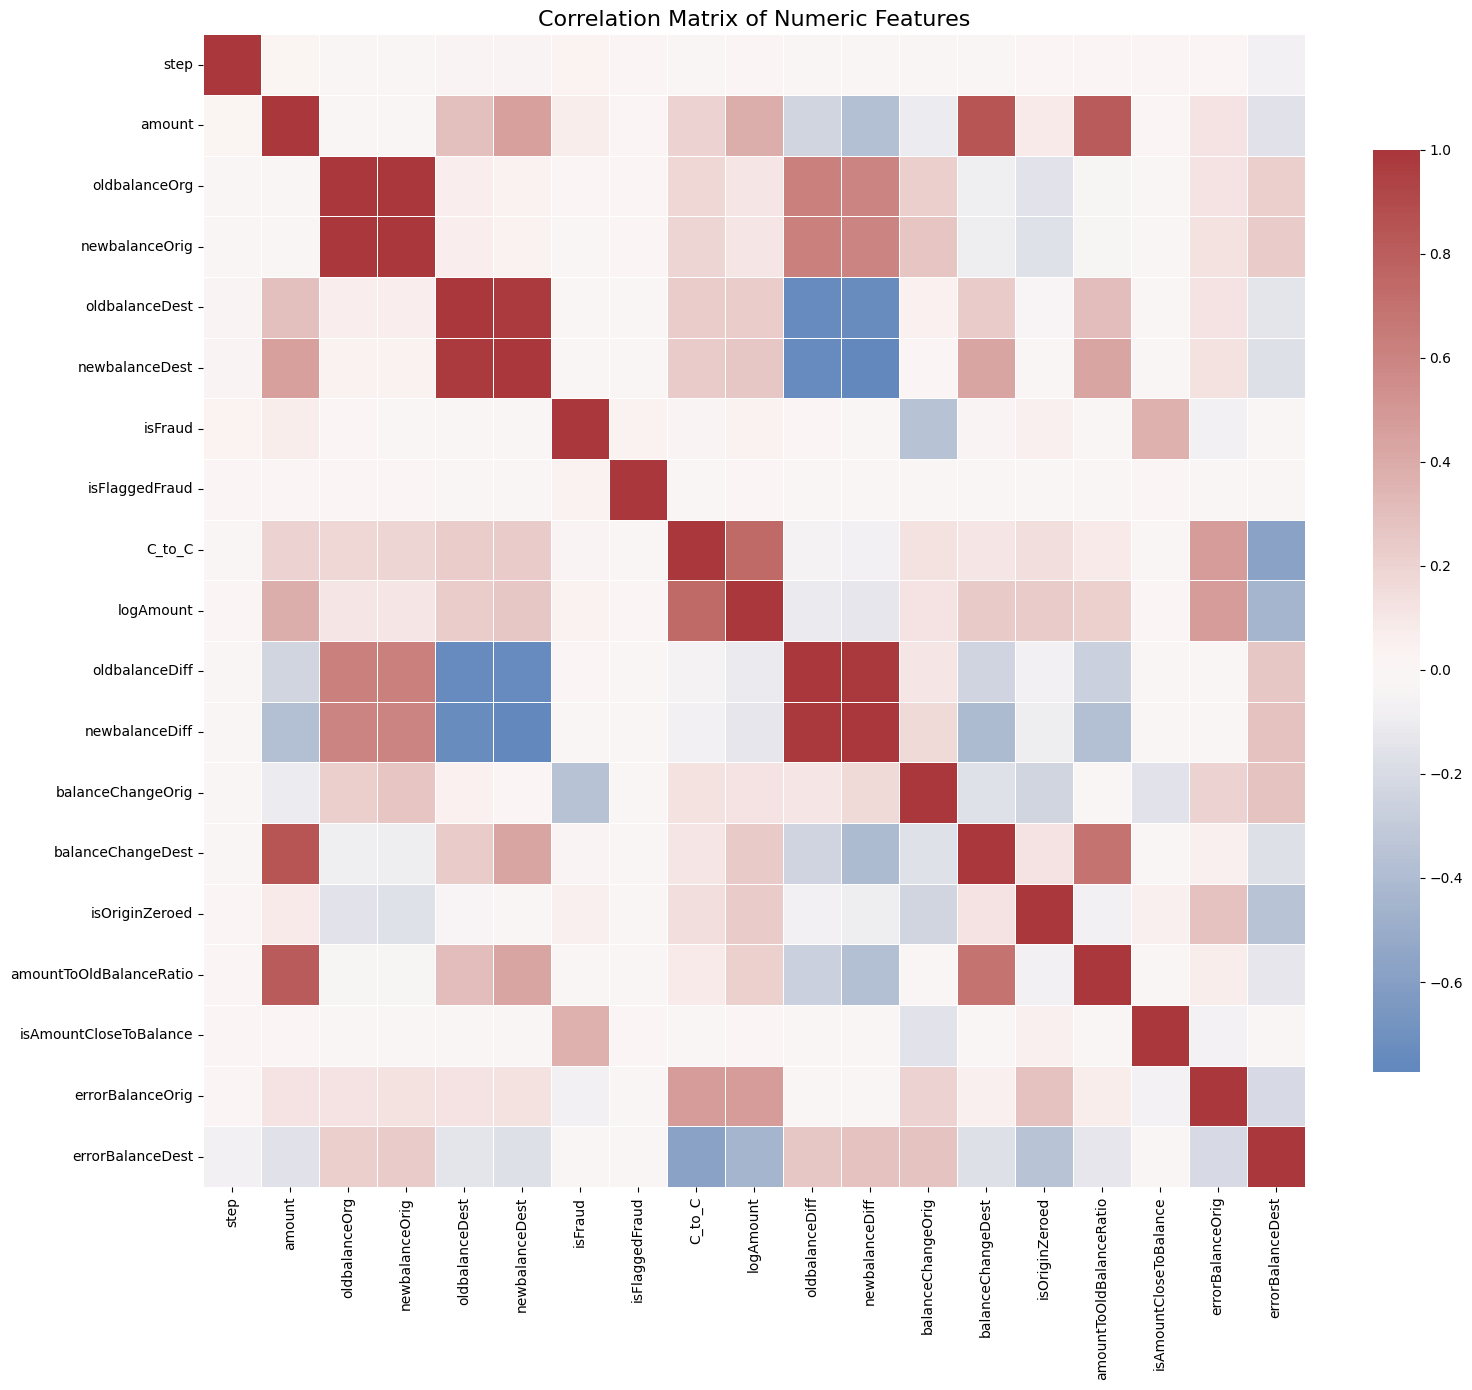

In [29]:
# Analyze correlations among engineered features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Select numerical columns only
numeric_df = engineered_df.select_dtypes(include=['int64', 'float64'])

# Compute corr matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16,14))
sns.heatmap(corr_matrix, annot=False, cmap='vlag', center=0, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

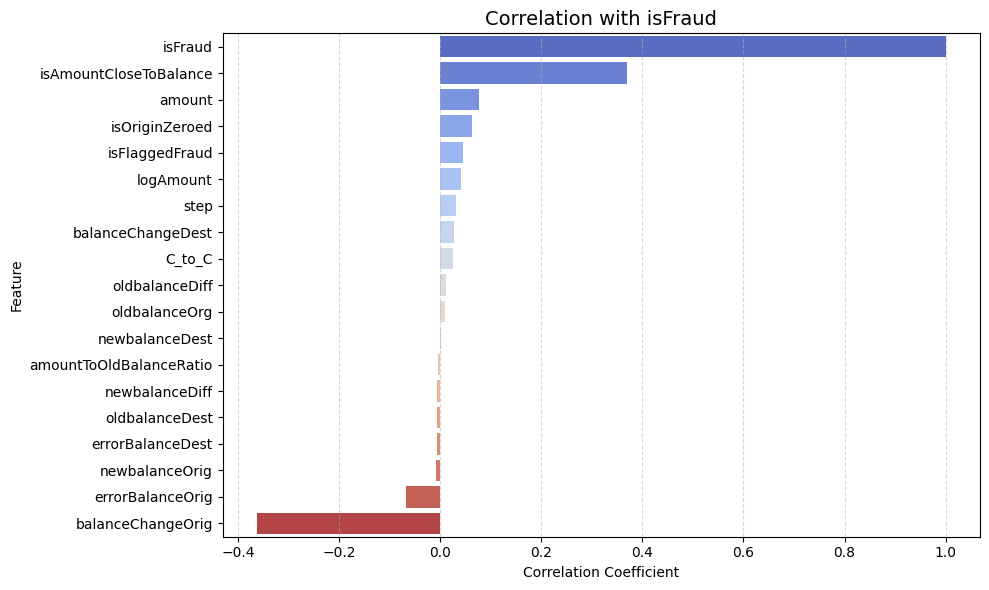

In [30]:
# Get correlation of all features with 'isFraud', sorted
fraud_corr = corr_matrix['isFraud'].sort_values(ascending=False)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_corr.values, y=fraud_corr.index, palette="coolwarm")
plt.title("Correlation with isFraud", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [31]:
# Calculate correlation with the target variable (isFraud)
target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(target_corr[:10])
print("\nBottom 10 features correlated with fraud:")
print(target_corr[-10:])

Top 10 features correlated with fraud:
isFraud                   1.000000
isAmountCloseToBalance    0.369755
amount                    0.076688
isOriginZeroed            0.062091
isFlaggedFraud            0.044109
logAmount                 0.040640
step                      0.031578
balanceChangeDest         0.027028
C_to_C                    0.025697
oldbalanceDiff            0.011440
Name: isFraud, dtype: float64

Bottom 10 features correlated with fraud:
oldbalanceDiff             0.011440
oldbalanceOrg              0.010154
newbalanceDest             0.000535
amountToOldBalanceRatio   -0.004910
newbalanceDiff            -0.005608
oldbalanceDest            -0.005885
errorBalanceDest          -0.006257
newbalanceOrig            -0.008148
errorBalanceOrig          -0.068412
balanceChangeOrig         -0.362472
Name: isFraud, dtype: float64


**Takeaways from Correlation Analysis**
<br>Positive correlations:
- `isAmountCloseToBalance` indicating account wipeouts displayed strongest positive signal (0.37) for fraud.
- `isOriginZeroed` is also a meaningful fraud indicator (0.06).

Negative correlations:
- `balanceChangeOrig` displayed strongest negative signal (-0.36), likely due to legitimate transactions typically maintain balance consistencies unlike frauds.
- `errorBalanceOrig` is slightly correlated with fraud (-0.07), meaning unexpected inconsistencies occur in fraud but not so common as we have assumed.

## Final Thoughts
While correlation analysis provided valuable initial insights into potential relationships between features and fraud labels, the predictive power of each feature engineered remain highly inconclusive. Given correlation assumes linearity, it does not account for nonlinear interactions or joint effects between variables.

The final assessment of feature importance will be performed during model training phase.

In [33]:
# Save engineered_df to pkl
engineered_df.to_pickle('../data/engineered_df.pkl')
print("Saved as Pickle to ../data/engineered_df.pkl")

Saved as Pickle to ../data/engineered_df.pkl
